In [1]:
# 用單個模型同時執行兩個分類任務:
#   age 分成8個classes
#   gender 分成2個classes
# mlp 每個全連接層的unit個數: 128 -- 8
#                  \_ 2
# trainning: 
#   改用generator產生資料給fit_generator
#   class_weight
#   random_state
#   callback: EarlyStop, model.save


#用少量資料
FULL_DATA = 0
per_cls_trn = 5 #250
per_cls_eval = 2 #10
#用全部資料
#FULL_DATA = 1

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 1
DROP_RATE = 0.4
#model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
model_folder_path = 'drive/My Drive/Tibame_AIoT_Project'
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/cleandataset'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# to measure execution time
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=7b742f583f6139fb0018c28d16a19f80668e72318ab0badf824c0adeb14c3f82
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [4]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

time: 110 ms


In [5]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 
time: 2.73 s


In [6]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 50.3MB/s 
     |████████████████████████████████| 3.0MB 50.9MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
time: 1min 28s


In [7]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
#import keras
#from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN
import numpy as np

time: 4 s


In [8]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf
time: 1.24 ms


In [9]:
# 資料集由csv檔案讀入, 也可新增其他的csv檔案來擴充資料
# df = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_wiki.csv')
# df_under10 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_under10.csv')
# df_over70 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_over70.csv')
# df = pd.concat([df, df_under10, df_over70])

time: 1.61 ms


In [10]:
# cleandata: 清除wiki資料集原本的一些年齡標註錯誤
df = pd.read_csv(os.path.join(img_folder_path, 'cleandata.csv'))

time: 3.66 s


In [11]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]


time: 15.1 ms


In [12]:
# 每10歲分一類,70歲以上歸為同一類,共8類
df['age_grp'] = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,70,110], right=False)
le = LabelEncoder()
le.fit(df['age_grp'].astype('str'))
df['age_cls'] = le.transform(df['age_grp'].astype('str'))
df

,full_path,gender,age,age_grp,age_cls
0,f10/36890678_1955-04-19_1970.jpg,0,10,"[10, 20)",1
1,f10/36891092_1993-04-22_2012.jpg,0,10,"[10, 20)",1
2,f10/36897260_1993-07-16_2013.jpg,0,10,"[10, 20)",1
3,f10/46804145_1994-05-25_2014.jpg,0,10,"[10, 20)",1
4,f10/46812040_1999-01-05_2014.jpg,0,10,"[10, 20)",1
...,...,...,...,...,...
40098,m0/img_3944_1.jpg,1,5,"[0, 10)",0
40099,m0/img_3944_2.jpg,1,5,"[0, 10)",0
40100,m0/img_3927_2.jpg,1,5,"[0, 10)",0
40101,m0/img_3433_1.jpg,1,5,"[0, 10)",0


time: 301 ms


In [13]:
df['age_cls'].value_counts().sort_index()

0     1883
1     4120
2    11230
3     6518
4     4618
5     4199
6     5074
7     2461
Name: age_cls, dtype: int64

time: 9.62 ms


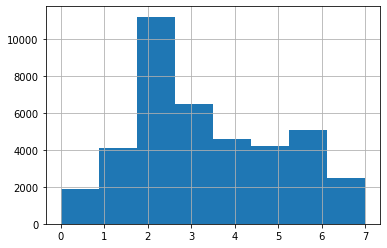

time: 286 ms


In [14]:
histogram_age = df['age_cls'].hist(bins=df['age_cls'].nunique())

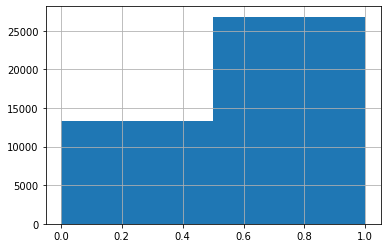

time: 147 ms


In [15]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [16]:
#先用少量資料比較不同模型:
#每個類別各取部分資料,用train_test_split來切train and test
df_f0 = df[(df['age_cls'] == 0) & (df['gender'] == 0)]
df_f1 = df[(df['age_cls'] == 1) & (df['gender'] == 0)]
df_f2 = df[(df['age_cls'] == 2) & (df['gender'] == 0)]
df_f3 = df[(df['age_cls'] == 3) & (df['gender'] == 0)]
df_f4 = df[(df['age_cls'] == 4) & (df['gender'] == 0)]
df_f5 = df[(df['age_cls'] == 5) & (df['gender'] == 0)]
df_f6 = df[(df['age_cls'] == 6) & (df['gender'] == 0)]
df_f7 = df[(df['age_cls'] == 7) & (df['gender'] == 0)]
df_m0 = df[(df['age_cls'] == 0) & (df['gender'] == 1)]
df_m1 = df[(df['age_cls'] == 1) & (df['gender'] == 1)]
df_m2 = df[(df['age_cls'] == 2) & (df['gender'] == 1)]
df_m3 = df[(df['age_cls'] == 3) & (df['gender'] == 1)]
df_m4 = df[(df['age_cls'] == 4) & (df['gender'] == 1)]
df_m5 = df[(df['age_cls'] == 5) & (df['gender'] == 1)]
df_m6 = df[(df['age_cls'] == 6) & (df['gender'] == 1)]
df_m7 = df[(df['age_cls'] == 7) & (df['gender'] == 1)]
# train and val data
if FULL_DATA == 1:
    #每個類別保留最後per_cls_eval筆資料作為evaluate用
    train_df = pd.concat([
        df_f0[:-per_cls_eval], df_f1[:-per_cls_eval], df_f2[:-per_cls_eval], df_f3[:-per_cls_eval], 
        df_f4[:-per_cls_eval], df_f5[:-per_cls_eval], df_f6[:-per_cls_eval], df_f7[:-per_cls_eval], 
        df_m0[:-per_cls_eval], df_m1[:-per_cls_eval], df_m2[:-per_cls_eval], df_m3[:-per_cls_eval], 
        df_m4[:-per_cls_eval], df_m5[:-per_cls_eval], df_m6[:-per_cls_eval], df_m7[:-per_cls_eval]         
        ])           
else:    
    #先用少量資料比較不同模型
    train_df = pd.concat([
        df_f0[:per_cls_trn], df_f1[:per_cls_trn], df_f2[:per_cls_trn], df_f3[:per_cls_trn], 
        df_f4[:per_cls_trn], df_f5[:per_cls_trn], df_f6[:per_cls_trn], df_f7[:per_cls_trn], 
        df_m0[:per_cls_trn], df_m1[:per_cls_trn], df_m2[:per_cls_trn], df_m3[:per_cls_trn], 
        df_m4[:per_cls_trn], df_m5[:per_cls_trn], df_m6[:per_cls_trn], df_m7[:per_cls_trn]         
        ])
    
# evaluate data: 每個類別保留最後per_cls_eval筆資料作為evaluate用
eval_df = pd.concat([
        df_f0[-per_cls_eval:], df_f1[-per_cls_eval:], df_f2[-per_cls_eval:], df_f3[-per_cls_eval:], 
        df_f4[-per_cls_eval:], df_f5[-per_cls_eval:], df_f6[-per_cls_eval:], df_f7[-per_cls_eval:],
        df_m0[-per_cls_eval:], df_m1[-per_cls_eval:], df_m2[-per_cls_eval:], df_m3[-per_cls_eval:], 
        df_m4[-per_cls_eval:], df_m5[-per_cls_eval:], df_m6[-per_cls_eval:], df_m7[-per_cls_eval:]         
        ])
x_eval = np.array(eval_df['full_path'])
# 先把模型的兩個輸出的答案合併
y_eval = np.array(pd.concat([eval_df['age_cls'], eval_df['gender']], axis=1))
print("train:", len(train_df), "predict:", len(eval_df))

train: 80 predict: 32
time: 106 ms


In [17]:
# 處理答案 把它轉成one-hot (後面再做)
# y_train_category = to_categorical(df['age_cls'], num_classes=8)

# 2個輸出: age, gender
y_df = pd.concat([pd.DataFrame(train_df['age_cls']), pd.DataFrame(train_df['gender'])], axis=1)

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df['full_path']), np.array(y_df), test_size=0.2, random_state=0)

print(x_train[0], x_test[0], y_train[0], y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

f0/170514_1963-03-06_1970.jpg m20/37807877_1987-08-20_2009.jpg [0 0] [2 1]
(64,) (16,) (64, 2) (16, 2)
time: 8.02 ms


In [18]:
detector = MTCNN()
#feature_extractor = load_model(os.path.join(model_folder_path, 'facenet_keras.h5'))

time: 411 ms


In [19]:
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='senet50', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

     |████████████████████████████████| 51kB 1.7MB/s 
104947712/104944616 [==============================] - 7s 0us/step
time: 17.2 s


In [20]:
#feature_extractor.summary()

time: 1.02 ms


In [21]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

x = Dropout(DROP_RATE)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(DROP_RATE)(x)
age = Dense(units=8, activation='softmax', name='age')(x)
gender = Dense(units=2, activation='softmax', name='gender')(x)

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# 2個輸出: age, gender
age_gender_model = Model(inputs=feature_extractor.input, outputs=[age, gender])   
age_gender_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [22]:
from keras.utils import plot_model
plot_model(age_gender_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
age_gender_model.compile(loss=["categorical_crossentropy","categorical_crossentropy"], 
                  optimizer='adam', metrics=[{'age':'accuracy'},{'gender':'accuracy'}]) # 2個輸出: age, gender
#age_gender_model.load_weights(os.path.join(model_folder_path,'21-1_senet_mlp128_bs64.h5'))
#model  =  load_model(os.path.join(model_folder_path,'31-1_senet_mlp128_bs64_save.h5'))

time: 70.1 ms


In [24]:
# # 資料預處理 for facenet?
# # Standardization
# def preprocess(imgs): 
#     for i in range(imgs.shape[0]):
#         # standardization
#         img = imgs[i]
#         mean, std = img.mean(), img.std()
#         img = (img - mean) / std
#         imgs[i] = img
#     return imgs
# # Normalization
# def normalize(img):
#     return img / 255.

# # -1 <= x <= 1
# def preprocess_1(imgs):
#     x = np.array(imgs, dtype = float)
#     x /= 127.5
#     x -= 1.
#     return x    

time: 2.1 ms


In [25]:
# detect face
def detect_faces(img):
    face_imgs = []

    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
     
    return face_imgs

time: 5.08 ms


In [26]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    """
    Generates data for Keras
    ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self,
                 paths,
                 y_cls,
                 batch_size,
                 #num_classes,
                 shuffle=False):
        self.paths = paths
        self.y_cls = y_cls
        self.batch_size = batch_size
        self.shuffle = shuffle
        #self.num_classes = num_classes
        self.indexes = np.arange(len(self.paths))
        #self.class_map = {'0':0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        batch_y = [self.y_cls[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_paths, batch_y)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, paths, y_cls):
        """
        Generates data containing batch_size samples
        """
        # X = np.empty((len(paths), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        # y = np.empty((len(paths), self.num_classes), dtype=np.float32)

        x_ori, x_norm, y_age, y_gender = [], [], [], []

        for i, path in enumerate(paths):
            #print("idx:", i, "cls:", y_cls[i], path)
        
            # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理           
            img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
            faces = detect_faces(img)
            if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
                print(' No face')
                continue
            #print(faces[0].shape)   
            img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))

            # 使用借來的模型的預處理方式來作預處理
            img_pre = preprocess_input(np.array(img_crop,dtype=float))
            
            # 把原圖留下來
            x_ori.append(img)
            x_norm.append(img_pre)
            y_age.append(y_cls[i][0])
            y_gender.append(y_cls[i][1])

            

        # print("len(image_data)",len(x_ori))
        # plt.figure(figsize=(10, 40))
        # for j,m in enumerate(x_ori):
        #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
        #     plt.title("idx:{} y_cls:{}".format(i_batch+j, y_cls[i_batch+j]))
        #     plt.axis("off")
        #     plt.imshow(m)
        # plt.show() 

        
        # 2個輸出: age, gender  
        # print(type(y_age), len(y_age), y_age[:8])
        # print(type(y_gender), len(y_gender), y_gender[:8])
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        # print(y_age_category)
        # print(y_gender_category)
        x_input = {'input_4':np.array(x_norm)}
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
        # print(type(np.array(x_norm)), np.array(x_norm).shape)
        # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

        #yield x_input, y_category
        return x_input, y_category

time: 138 ms


In [27]:
# 用generator產生資料
generator_train = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
generator_test = DataGenerator(x_test, y_test, batch_size=BATCH_SIZE)
#type(generator_train)

time: 1.55 ms


In [28]:
# if FULL_DATA == 1:
#     age_weights = {0:12., 1:5., 2:1., 3:2., 4:3., 5:4., 6:6., 7:3.}
# else:    
#     # for temp
#     age_weights = {0:1., 1:1., 2:1., 3:1., 4:1., 5:1., 6:1., 7:1.}

# data_count = np.unique(np.argmax(y_train, axis=-1), return_counts=True)[1]
# data_count
# num_classes=8
# age_weights = (1/data_count)*np.sum(data_count)/num_classes
# class_weight = {i: w for i, w in enumerate(age_weights)}
# print('class_weight', class_weight)

time: 1.83 ms


In [29]:
# fit_generator
checkpoint = ModelCheckpoint(os.path.join(model_folder_path,"31-1_senet_mlp128_bs64_test_ep{epoch}_{val_age_accuracy:.4f}_{val_gender_accuracy:.4f}.h5"), 
               save_best_only=False, save_weights_only=False)   #Defaults: save_freq='epoch', save_weights_only=False
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
#logs = age_gender_model.fit_generator(
logs = age_gender_model.fit( 
        generator_train,
        #steps_per_epoch=len(x_train)//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=generator_test,
        #validation_steps=len(x_test)//BATCH_SIZE,
        callbacks=[checkpoint, earlystop] 
        )

1/1 [==============================] - 24s 24s/step - loss: 4.6459 - age_loss: 3.8454 - gender_loss: 0.8005 - age_accuracy: 0.1250 - gender_accuracy: 0.6562 - val_loss: 7.2855 - val_age_loss: 6.8321 - val_gender_loss: 0.4535 - val_age_accuracy: 0.1250 - val_gender_accuracy: 0.8125
time: 3min 18s


In [30]:
age_gender_model.save(os.path.join(model_folder_path,'31-1_senet_mlp128_bs64_save_test.h5'))

time: 898 ms


In [31]:
model = load_model(os.path.join(model_folder_path,"31-1_senet_mlp128_bs64_save_test.h5"))

time: 3.68 s


In [32]:
!pip install keras2onnx

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 7.4MB 5.5MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=79abe1ba5da90bfa73034060b5f65cc3a4a3067af01cc0e92469ab95dba96247
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire
time: 7.5 s


In [33]:
# convert to onnx model
import keras2onnx
onnx_model = keras2onnx.convert_keras(model, model.name)

tf executing eager_mode: True
tf.keras model eager_mode: False


KeyboardInterrupt: ignored

time: 49min 7s


In [ ]:
keras2onnx.save_model(onnx_model, os.path.join(model_folder_path,'senet_128_test.onnx'))

In [ ]:
history = logs.history
history

In [ ]:
plt.plot(history['age_accuracy'])
plt.plot(history['val_age_accuracy'])
plt.legend(['age_accuracy', 'val_age_accuracy'])
plt.title('age_accuracy')
plt.show()

In [ ]:
plt.plot(history['gender_accuracy'])
plt.plot(history['val_gender_accuracy'])
plt.legend(['gender_accuracy', 'val_gender_accuracy'])
plt.title('gender_accuracy')

In [ ]:
plt.plot(history['age_loss'])
plt.plot(history['val_age_loss'])
plt.legend(['age_loss', 'val_age_loss'])
plt.title('age_loss')

In [ ]:
plt.plot(history['gender_loss'])
plt.plot(history['val_gender_loss'])
plt.legend(['gender_loss', 'val_gender_loss'])
plt.title('gender_loss')

In [ ]:
# 取得要預測的圖片並做預處理
def get_preprocess_images(data_paths, y_data, batch_size=BATCH_SIZE):
    n = len(data_paths)
    # i = 0
    # data_paths = data_paths
    
    #while i < n:    
    x_ori, x_norm, y_age, y_gender = [], [], [], []
    #i_batch = i
    for idx in range(batch_size):
        path = data_paths[idx]
        #print("n:", n, "idx:", i, "cls:", y_data[i], path)
    
        # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
        try:          
            img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
        except:
            print('imread failed')
            idx = idx + 1
            continue                   
        
        faces = detect_faces(img)
        if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
            print('No face')
            idx = idx + 1
            continue   
        # print(faces[0].shape)    
        img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
        

        # 使用借來的模型的預處理方式來作預處理
        img_pre = preprocess_input(np.array(img_crop, dtype=float))

        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
        if len(y_data) != 0:
            y_age.append(y_data[idx][0])
            y_gender.append(y_data[idx][1])
        
        idx = idx + 1


    # print("len(image_data)",len(x_ori))
    # plt.figure(figsize=(10, 40))
    # for j,m in enumerate(x_ori):
    #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
    #     plt.title("idx:{} y_data:{}".format(i_batch+j, y_data[i_batch+j]))
    #     plt.axis("off")
    #     plt.imshow(m)
    # plt.show() 

    
    # 2個輸出: age, gender  
    # print(type(y_age), len(y_age), y_age[:8])
    # print(type(y_gender), len(y_gender), y_gender[:8])
    if len(y_data) != 0:
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
    else:
        y_category = []

    # print(type(np.array(x_norm)), np.array(x_norm).shape)
    # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

    return np.array(x_ori), np.array(x_norm), y_category
    #print('while end', i, n)

In [ ]:
# evaluate
#
# 從保留作為evaluate用的資料,用generator產生資料 to predict
x_ori, x_input, y_category = get_preprocess_images(x_eval, y_eval, batch_size=len(x_eval))

# 取出圖片資料與正確答案
x_eval_data, y_true_age, y_true_gender = [], [], []
for i,x in enumerate(x_input):
    # print("x_eval_data:", len(list(x_dict['input_4'])))
    x_eval_data.append(x)
    # print("y_true_age:", y_dict['age'].argmax(axis=-1))
    # print("y_true_gender:", y_dict['gender'].argmax(axis=-1))    
    y_true_age.append( (list(y_category['age'])[i].argmax(axis=-1)) )
    y_true_gender.append( (list(y_category['gender'])[i].argmax(axis=-1)) )

# print("-------------------------")
print("x_eval_data:", type(x_eval_data), "np.array:", np.array(x_eval_data).shape, x_eval[:8])
print("y_true_age:", y_true_age)
print("y_true_gender:", y_true_gender)

In [ ]:
# predict
pre = age_gender_model.predict(np.array(x_eval_data))
#pre[0] is predicted probabilities for age
#pre[1] is predicted probabilities for gender
pred_age = pre[0].argmax(axis=-1)
pred_gender = pre[1].argmax(axis=-1)
print("predict age:",pred_age)
print("predict gender:",pred_gender)

In [ ]:
len(pred_age), len(pred_gender)

In [ ]:
from sklearn.metrics import classification_report
print(np.array(y_true_age).shape, np.array(pred_age).shape, np.array(y_true_gender).shape, np.array(pred_gender).shape)
age_target_names = [str(i) for i in range(8)]
gender_target_names = [str(i) for i in range(2)]
print(classification_report(np.array(y_true_age), np.array(pred_age), target_names=age_target_names))
print(classification_report(np.array(y_true_gender), np.array(pred_gender), target_names=gender_target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_true_age, pred_age),
            index=["{}(真實)".format(i) for i in range(8)],
            columns=["{}(預測)".format(i) for i in range(8)] 
            )

In [ ]:
pd.DataFrame(confusion_matrix(y_true_gender, pred_gender),
            index=["{}(真實)".format(i) for i in range(2)],
            columns=["{}(預測)".format(i) for i in range(2)] 
            )